In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
from scipy.stats import ttest_ind
from scipy.stats import shapiro, anderson, kstest, norm
import pickle

#data = pd.read_csv('data/wnba_train_over_under_data.csv')
df= pd.read_csv('data/wnba_train_regression.csv')
OU = df['OU Result']
df.drop(['OU Result'], axis=1, inplace=True)

class_counts = OU.value_counts()
print(class_counts)


# Load the model from the file
with open('linear_regression_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

relative_performance = df['Relative Performance']

shifted_relative_performance = relative_performance - relative_performance.min() + 1  # Shift to make all values positive
sqrt_relative_performance = np.sqrt(shifted_relative_performance)

# Now you can use the loaded model to make predictions
predictions = loaded_model.predict(np.array(sqrt_relative_performance).reshape(-1, 1))

# Print point
df['Adjusted Points'] = df['DARKO'] + predictions
df["DARKO L10"] = df["DARKO"] - df["L10 Median"]
df["Difference"] = df["Points"] - df["L10 Median"]
#df["Line Residual"] = df['Line'] - df["Points"]
df["DARKO Difference"] = df["Points"] - df["DARKO"]
print(df.describe())

print(df[df["Difference"] > 5])


OU Result
0.0    280
1.0    221
Name: count, dtype: int64
       L10 Median      Kalman       DARKO  Relative Performance        Home  \
count  501.000000  501.000000  501.000000            501.000000  501.000000   
mean    15.530938   15.789969   15.678949              0.741158    0.514970   
std      4.260932    4.258370    4.209996              9.787048    0.500275   
min      7.000000    6.422565    7.245753            -23.266667    0.000000   
25%     12.500000   12.744722   12.620806             -6.000000    0.000000   
50%     15.000000   15.076374   15.048328              0.266667    1.000000   
75%     18.500000   18.521122   18.054334              8.200000    1.000000   
max     29.000000   29.872336   29.052440             22.157895    1.000000   

         Recent T      Spread      Points        Line  Adjusted Points  \
count  501.000000  501.000000  501.000000  501.000000       501.000000   
mean     0.065854    0.922156   15.652695   15.835329        12.089005   
std     

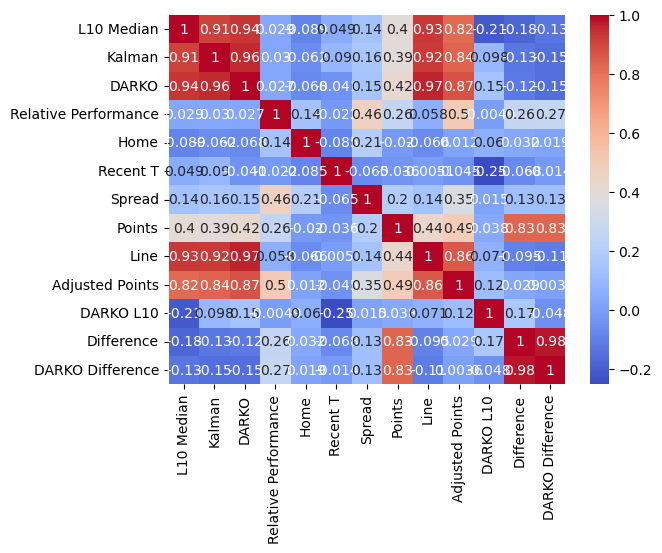

In [2]:
# Correlation matrix
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


In [19]:

# Perform independent samples t-test
# Statitical difference between home and away games avarage?

# Is there a significant difference between players that seem to be doing well recently
cutoff = 1
points_home_0 = df[df["Recent T"] <= cutoff]["Difference"].values
points_home_1 = df[df["Recent T"] > cutoff]["Difference"].values
print(len(points_home_0), len(points_home_1))
t_stat, p_value = ttest_ind(np.array(points_home_0), np.array(points_home_1))
print(t_stat)
print(p_value)

# Home and Away?

# Kolmogorov-Smirnov Test
# slightly right skewed
data = np.array(df['Points'])
kstest_stat, kstest_p = kstest(data, 'norm', args=(np.mean(data), np.std(data)))
print(f'Kolmogorov-Smirnov Test: Statistic={kstest_stat}, p-value={kstest_p}')
if kstest_p > 0.05:
    print("Sample looks Gaussian (fail to reject H0)")
else:
    print("Sample does not look Gaussian (reject H0)")

# Residuals are NOT normally distributed -- suggests that a Kalman filter purely applied cannot be the best option

# Slight overprediction for home games
"""
points_home_0 = df[df["Home"] == 0]["Line Residual"].values
points_home_1 = df[df["Home"] == 1]["Line Residual"].values
print(len(points_home_0), len(points_home_1))
t_stat, p_value = ttest_ind(np.array(points_home_0), np.array(points_home_1))
print(t_stat)
print(p_value)
"""

"""
# Basic info and statistics
print(df.info())
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Visualizations
# Histograms
df.hist(bins=30, figsize=(10, 10))
plt.show()

# Boxplots
df.boxplot(column=['Points', 'Minutes Diff', 'Opponent PPG', 'Rest Days'], figsize=(10, 6))
plt.show()


# Scatter plots


sns.pairplot(df, x_vars=['Points', 'Minutes Diff', 'Rest Days', 'Recent T'], y_vars='OU Result', height=5, aspect=0.8)
plt.show()

# Bar plot for the categorical variable 'Home'
sns.barplot(x='Home', y='OU Result', data=df)
plt.show()
"""

443 58
0.5292917987039728
0.5968384204881588
Kolmogorov-Smirnov Test: Statistic=0.056047325645116275, p-value=0.0826862196272039
Sample looks Gaussian (fail to reject H0)


'\n\n# Calculate the correlation between Rest Days and Difference\ncorrelation = df[\'My PPG\'].corr(df[\'Difference\'])\nprint(f"Correlation between Rest Days and Difference (L10 Median - Points): {correlation}")\n\n# Basic info and statistics\nprint(df.info())\nprint(df.describe())\n\n# Check for missing values\nprint(df.isnull().sum())\n\n# Visualizations\n# Histograms\ndf.hist(bins=30, figsize=(10, 10))\nplt.show()\n\n# Boxplots\ndf.boxplot(column=[\'Points\', \'Minutes Diff\', \'Opponent PPG\', \'Rest Days\'], figsize=(10, 6))\nplt.show()\n\n\n# Scatter plots\n\n\nsns.pairplot(df, x_vars=[\'Points\', \'Minutes Diff\', \'Rest Days\', \'Recent T\'], y_vars=\'OU Result\', height=5, aspect=0.8)\nplt.show()\n\n# Bar plot for the categorical variable \'Home\'\nsns.barplot(x=\'Home\', y=\'OU Result\', data=df)\nplt.show()\n'

In [16]:
# Estimate median absolute error for all estimators
print(f"Kalman Error: {mean_absolute_error(df['Points'], df['Kalman'])}")
print(f"Line Error: {mean_absolute_error(df['Points'], df['L10 Median'])}")
print(f"L10 Median Error: {mean_absolute_error(df['Points'], df['Line'])}")
print(f"DARKO Error: {mean_absolute_error(df['Points'], df['DARKO'])}") 
print(f"Adjusted Points Error: {mean_absolute_error(df['Points'], df['Adjusted Points'])}") 

#5.46 with median, 0.98
# with median, 0.99
#5.476 with mean, 0.98
#5.41 with mean, 0.98
#5.486 with mean, 0.99

# L10 Median is a LESS BIASED estimator of the median of points than the line itself 
# best unbiased estimator is L10 Median, but it doesn't get the side 

Kalman Error: 5.654536817338657
Line Error: 5.5489021956087825
L10 Median Error: 5.458083832335329
DARKO Error: 5.50830845991215
Adjusted Points Error: 5.906420837109427


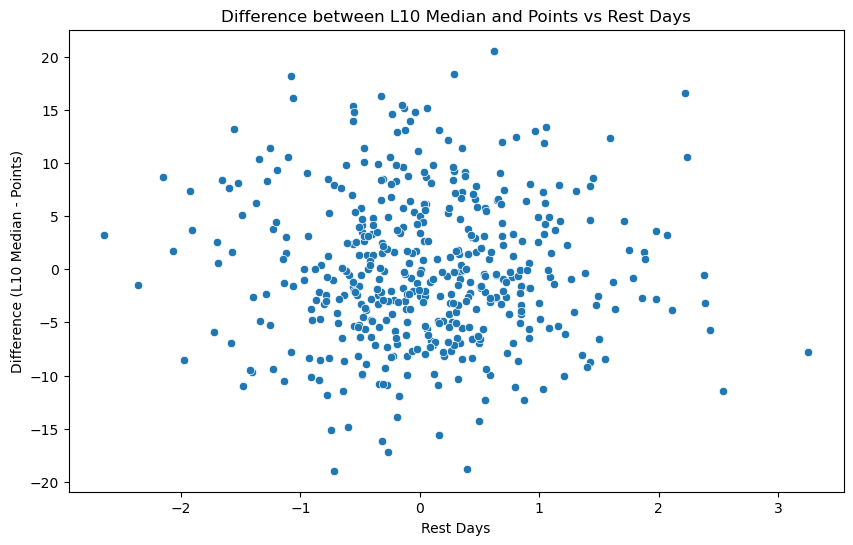

In [17]:

# Plot the difference against Rest Days
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Recent T', y='DARKO Difference')
plt.title('Difference between L10 Median and Points vs Rest Days')
plt.xlabel('Rest Days')
plt.ylabel('Difference (L10 Median - Points)')
plt.show()

# Relative performance vs team performance
# We should really be seeing a PARABOLIC trend -- player performance is maximized if it is a close game (i.e. points = -10 to 10) and minimized otherwise (points = 20 and above)

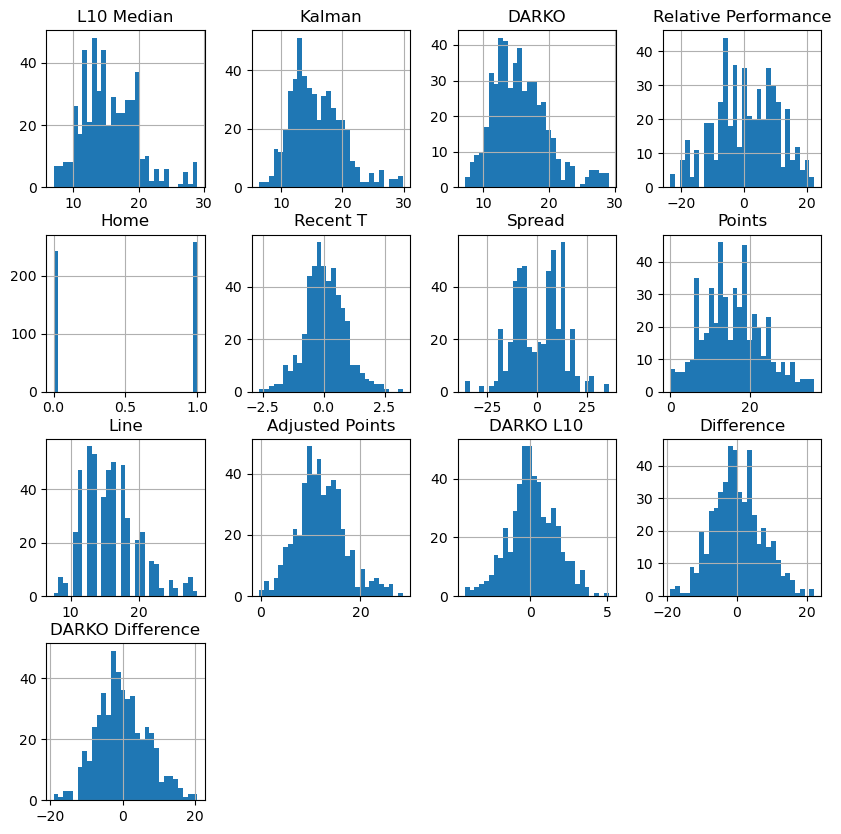

In [18]:
# Histograms
df.hist(bins=30, figsize=(10, 10))
plt.show()